# Reinforcement Learning Tarea 3 - Métodos Monte Carlo (blackjack)

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en [Gymnasium](https://gymnasium.farama.org/index.html), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El [ambiente de gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 


## Descripción del ambiente a usar

### Reglas del juego

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable" y es su valor por defecto.
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador se queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

### Implementación en Gymnasium

- La reward por perder es -1, por ganar es +1 y por pedir carta es 0. En caso de empate, la reward es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

Revisa el [ambiente en gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) para entender como funciona.


### A entregar

- Notebook con solución a los algoritmos presentados
- Analisis de la función de valor estimada para distinto número de episodios a visitar (ej: 100, 10000, 50000, 500000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de función de valor para otras politicas definidas por el estudiante (al menos una). 

In [454]:
import gymnasium as gym
from gymnasium.utils.play import play
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from Utils import plot_value_distribution, plot_Q_distribution

In [455]:
# Nos asegurams que las gráficas se muestren en el notebook
import matplotlib
%matplotlib inline

 Vemos el espacio de estado y acción del ambiente de blackjack.

In [456]:
# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [457]:
# vemos un ejemplo de observación
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")

Jugador: 9, Dealer: 7, As usable: 0 


Simulemos una partida de blackjack.

In [458]:
# Caso de prueba
state,_ = env.reset()
print('initial state:', state)

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    print('state:', state, 'reward:', reward, 'done:', done)
    if done or truncated:
        print(f'Reward: {reward}')                
        break

initial state: (21, 4, 1)
state: (12, 4, 0) reward: 0.0 done: False
state: (18, 4, 0) reward: 0.0 done: False
state: (19, 4, 0) reward: 0.0 done: False
state: (19, 4, 0) reward: 1.0 done: True
Reward: 1.0


## Predicción de la función de valor ($V$ y $Q$)

Vamos a implementar el algoritmo de Monte Carlo para estimar las funciones de valor $V$ y $Q$ para el ambiente de blackjack asi como algunas variantes (first visit, every visit, exploración inicial, etc).

Para ello primero vamos a definir una politica: Si suma 20 o más, se queda (STICK), si no pide carta (HIT). Esta política es la que se usa en el ejemplo del libro.

In [459]:
STICK = 0
HIT = 1
       
## Politica Sutton & Barto
def sutton_policy(observation):
    sum, _, _ = observation
    return STICK if sum >= 20 else HIT

### Generación de episodios

Vamos a implementar una función que genere episodios de la política definida. La función va a recibir el ambiente y la política y va a devolver una lista de transiciones (estado, acción, reward, next_state).

In [460]:
def generate_episode(policy, env,seed=None):
    """
    Genera un episodio utilizando la política dada.
    Args:
        policy: Función que toma un estado y devuelve una acción.
        env: Entorno de OpenAI Gym.
    Returns:
        episode: Lista de tuplas (estado, acción, recompensa, siguiente_estado).
    """
    episode = []
    state, _ = env.reset(seed=seed)  # Reinicia el entorno y establece una semilla para la reproducibilidad
    done = False
    while not done:
        action = policy(state)
        new_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, new_state))
        done = terminated or truncated
        state = new_state

    return episode
        


In [461]:
# lo probamos
episode = generate_episode(sutton_policy, env)
print("Episodio generado:")
for state, action, reward, next_state in episode:
    print(f"Estado: {state}, Acción: {action} ({'Hit' if action == 1 else 'Stick'}), Recompensa: {reward}, Siguiente estado: {next_state}")

Episodio generado:
Estado: (6, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (9, 10, 0)
Estado: (9, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (11, 10, 0)
Estado: (11, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (20, 10, 0)
Estado: (20, 10, 0), Acción: 0 (Stick), Recompensa: 1.0, Siguiente estado: (20, 10, 0)


### First-Visit MC para estimar $V$

El primer algoritmo que vamos a implementar es el de Monte Carlo First Visit. Este algoritmo estima la función de valor $V$ para una política dada.

$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }v_\pi\text{):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{política a evaluar.}\\
& \quad \text{(Se asume que podemos generar episodios con } \pi\text{.)}\\[6pt]
\textbf{Inicializar:} 
& \quad V(s) \in \mathbb{R}, \quad \forall\, s \in S \quad (\text{valores arbitrarios})\\
& \quad \text{Returns}(s) \leftarrow \varnothing, \quad \forall\, s \in S.\\[6pt]
\textbf{Bucle (por cada episodio):} 
& \\[-2pt]
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\, T-2,\, \ldots,\, 0:\\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } S_t \notin \{S_0, S_1, \ldots, S_{t-1}\}:\\
& \quad\quad\quad \text{Returns}(S_t) \leftarrow \text{Returns}(S_t) \cup \{G\}.\\
& \quad\quad\quad V(S_t) \leftarrow \text{average}\bigl(\text{Returns}(S_t)\bigr).\\[6pt]
\textbf{Retornar:} 
& \quad V.
\end{aligned}
$$

> Tip: con [defaultdict](https://docs.python.org/3/library/collections.html#defaultdict-objects) podemos definir un diccionario con un valor por defecto.

In [462]:
A = defaultdict(float)
B = defaultdict(int)
C = defaultdict(lambda: [])

print(A[999])
print(B[999])
print(C[999])

0.0
0
[]


In [463]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1.0):
    V = defaultdict(float)  # Valor estimado de cada estado
    returns = defaultdict(lambda:[])  # Lista de retornos para cada estado
    for i in tqdm(range(number_episodes)):
        episode = generate_episode(policy, env,i)
        G = 0  # Retorno
        T = len(episode)
        t = T-1
        while t>= 0:
            state, _, reward, _ = episode[t]
            G = reward + gamma * G
            # Solo consideramos el primer estado visitado en el episodio
            if state not in [x[0] for x in episode[:t]]:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
            t -= 1
    return V
    

In [464]:
sab_value = first_visit_mc_prediction(sutton_policy, env, number_episodes=50000)

100%|██████████| 50000/50000 [00:08<00:00, 5792.81it/s]


In [465]:
print(sab_value)

defaultdict(<class 'float'>, {(16, 10, 0): np.float64(-0.6704211557296768), (13, 10, 0): np.float64(-0.6395348837209303), (12, 10, 0): np.float64(-0.5968992248062015), (11, 10, 0): np.float64(-0.05947136563876652), (20, 7, 0): np.float64(0.760053619302949), (19, 10, 0): np.float64(-0.7528334786399302), (14, 10, 0): np.float64(-0.6227364185110664), (6, 10, 0): np.float64(-0.5), (17, 10, 0): np.float64(-0.7143522833178005), (7, 10, 0): np.float64(-0.5816326530612245), (21, 9, 1): np.float64(0.9861111111111112), (17, 6, 0): np.float64(-0.6692307692307692), (12, 6, 0): np.float64(-0.5578703703703703), (14, 6, 0): np.float64(-0.5887640449438202), (17, 2, 0): np.float64(-0.6925996204933587), (20, 8, 0): np.float64(0.7852257181942545), (20, 10, 0): np.float64(0.41928934010152286), (14, 2, 0): np.float64(-0.6406570841889117), (18, 8, 0): np.float64(-0.6363636363636364), (16, 8, 0): np.float64(-0.6481876332622601), (15, 10, 0): np.float64(-0.6650074664011946), (5, 10, 0): np.float64(-0.52023121

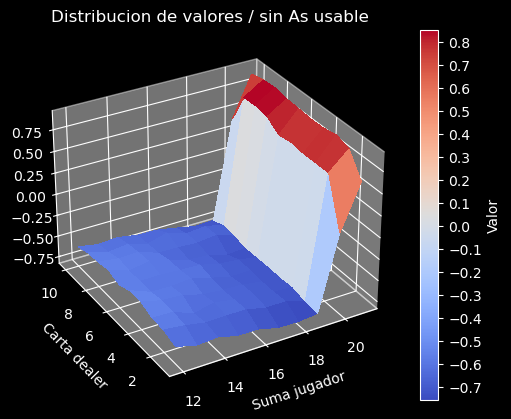

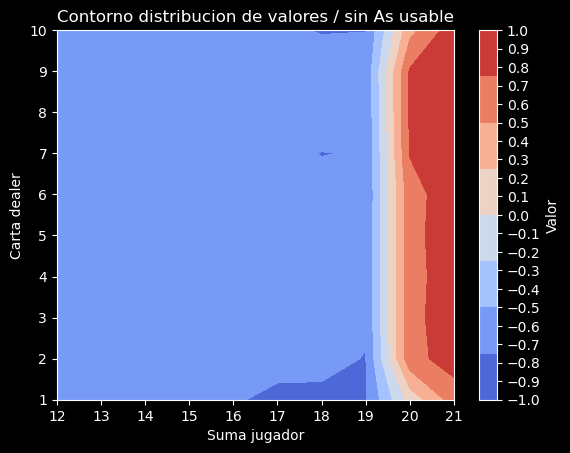

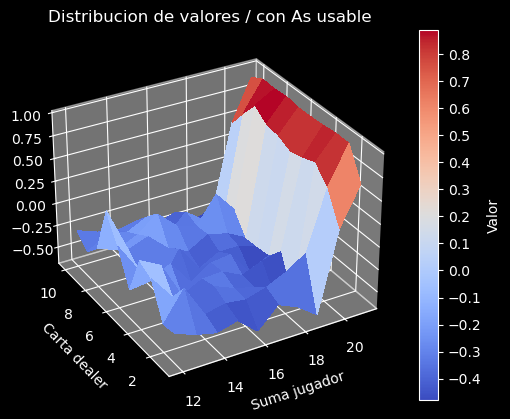

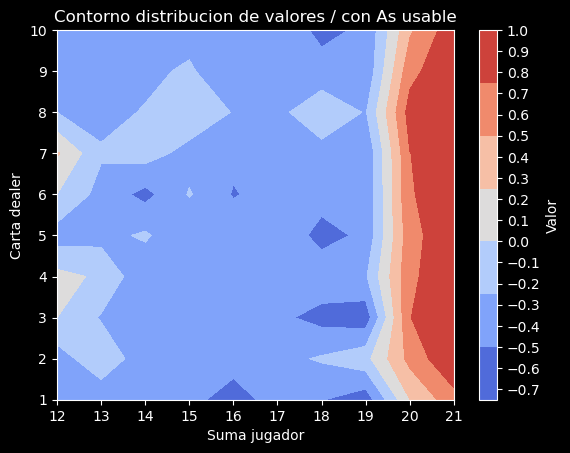

In [466]:
plot_value_distribution(sab_value)

In [467]:
type(sab_value)

collections.defaultdict

Una estrategía más elaborada, basada en Edward Thorp, que se basa en la carta del dealer y la suma del jugador. La idea es que si el dealer tiene una carta baja (2-6) el jugador se queda si tiene 12 o más, si no pide carta. Si el dealer tiene una carta alta (7-10) el jugador se queda si tiene 17 o más, si no pide carta.

100%|██████████| 500000/500000 [05:04<00:00, 1643.78it/s]


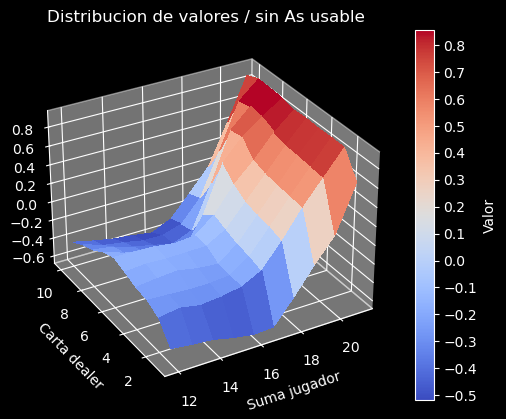

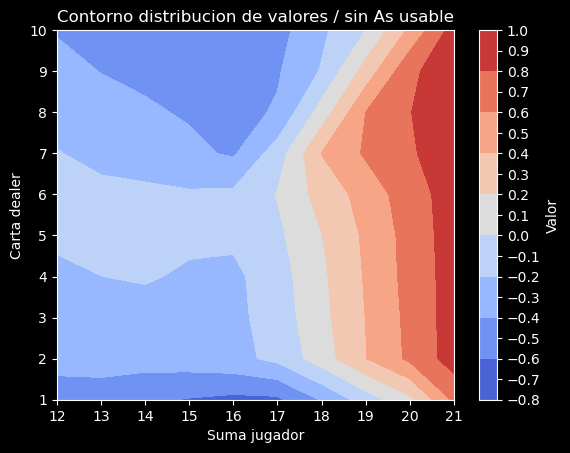

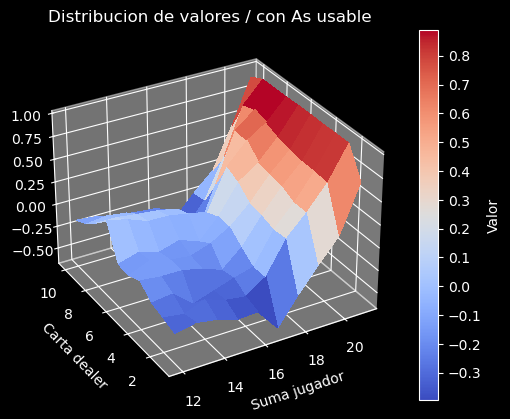

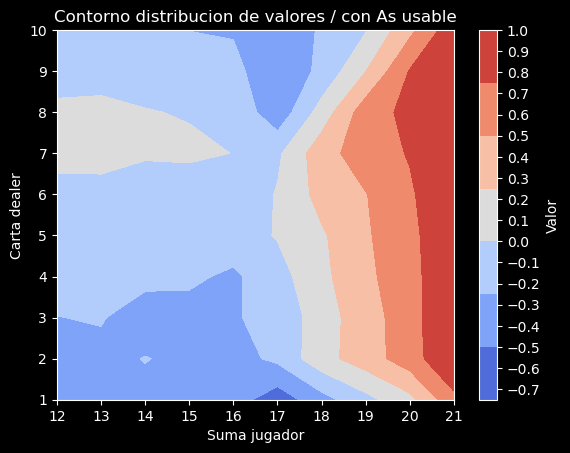

In [468]:
def thorp_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    if 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse.
    return STICK

thorp_value = first_visit_mc_prediction(thorp_policy, env, number_episodes=500000)

plot_value_distribution(thorp_value)

> 1) ¿Qué valores se esperan de $V$ si implementamos el algoritmo de Monte Carlo Every Visit en este caso? ¿Por qué?
> 2) Definir una política diferente que tenga en cuenta el As usable y estimar su función de valor. 

1) En blackjack, durante un mismo episodio, no se puede pasar 2 veces por un mismo estado, por lo que hacer MC Every Visit no debería representar un cambio en V respecto del estimado por MC first Visit.

Para comprobarlo, implementamos el algoritmo MC every visit, generamos exactamente los mismos episodios para ambos algoritmos mediante el uso de una semilla en cada env.reset() y comparamos los V resultantes. 

Implementamos MC Every Visit para estimar V

In [469]:
def every_visit_mc_prediction(policy, env, number_episodes, gamma=1.0):
    V = defaultdict(float)  # Valor estimado de cada estado
    returns = defaultdict(lambda:[])  # Lista de retornos para cada estado
    for i in tqdm(range(number_episodes)):
        episode = generate_episode(policy, env,i)
        G = 0  # Retorno
        T = len(episode)
        t = T-1
        while t>= 0:
            state, _, reward, _ = episode[t]
            G = reward + gamma * G
            # Consideramos todos los estados visitados en el episodio
            returns[state].append(G)
            V[state] = np.mean(returns[state])
            t -= 1
    return V
    

Estimamos V con el algoritmo Every Visit para la política del libro

In [470]:
sab_value_every_visit = every_visit_mc_prediction(sutton_policy, env, number_episodes=50000)

100%|██████████| 50000/50000 [00:09<00:00, 5098.96it/s]


Hacemos la diferencia del valor de cada estado estimado por ambos algoritmos (Every Visit y First Visit)

In [471]:
sab_dif = {k: sab_value[k] - sab_value_every_visit[k] for k in sab_value if k in sab_value_every_visit}

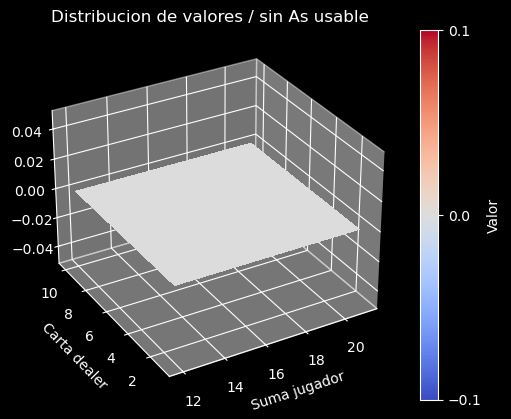

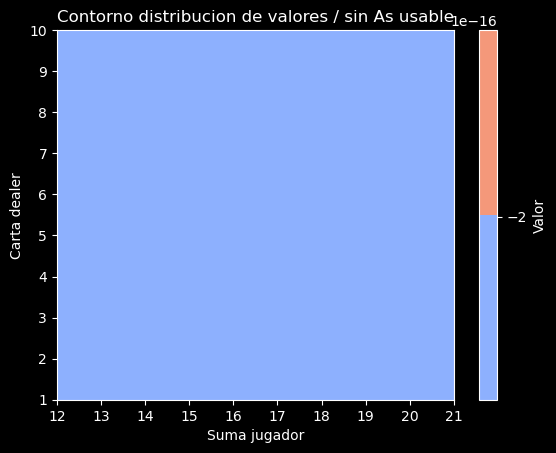

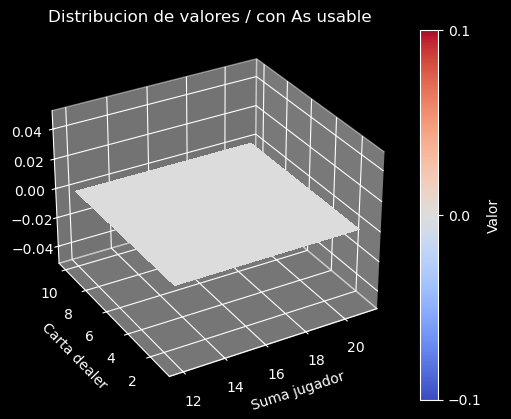

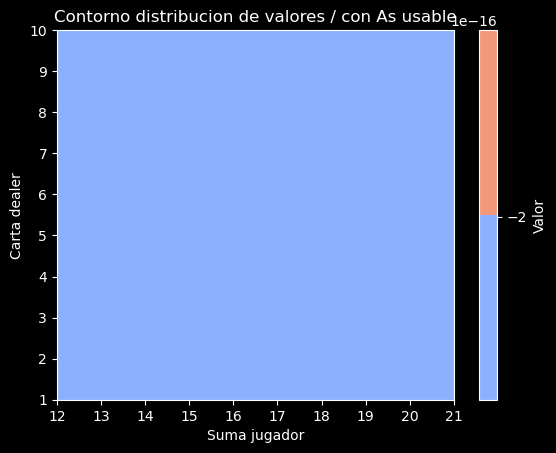

In [472]:
plot_value_distribution(sab_dif)

Los gráficos nos muestran que el V resultante de la diferencia entre V para MC First Visit y V para MC Every Visit son iguales.

2) Definimos una política partiendo de la thorp policy, con la diferencia que si el agente tiene una suma entre 12 y 16 y un as usable pide otra carta sin importar la carta del dealer. 

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:08<00:00, 5583.50it/s]


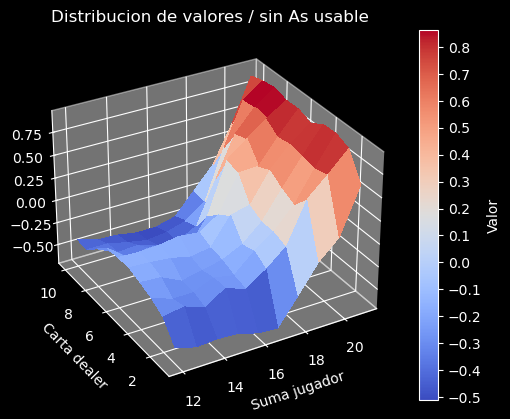

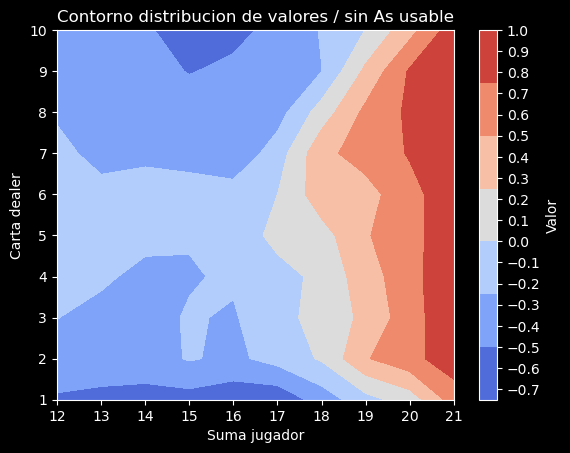

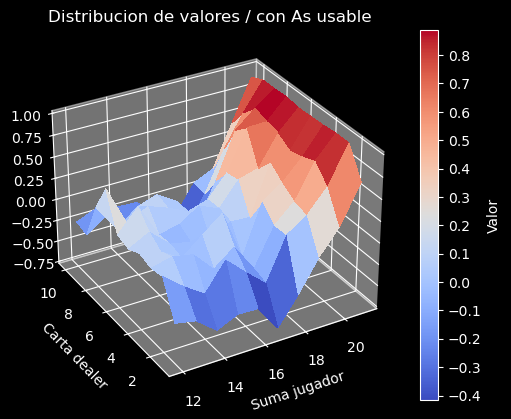

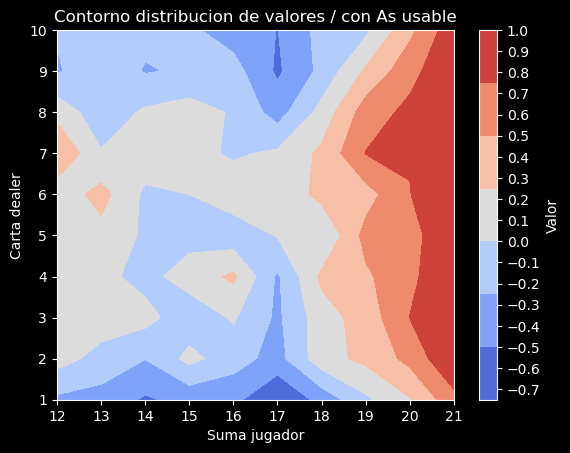

In [473]:
def usable_a_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    if 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6 and not usable_ace:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse.
    return STICK

usable_a_policy_value = first_visit_mc_prediction(usable_a_policy, env, number_episodes=50000)

plot_value_distribution(usable_a_policy_value)

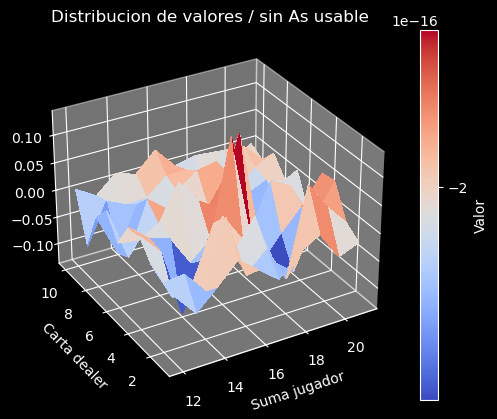

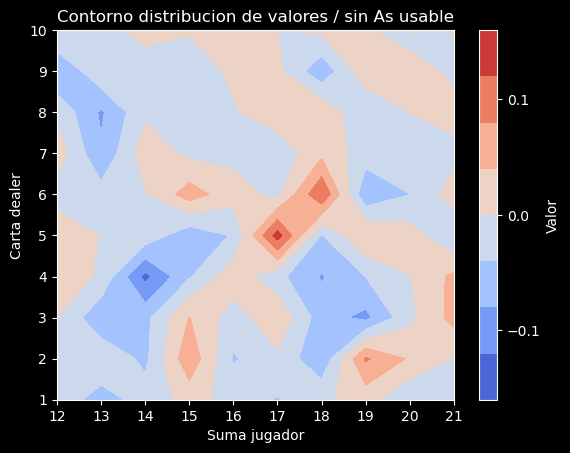

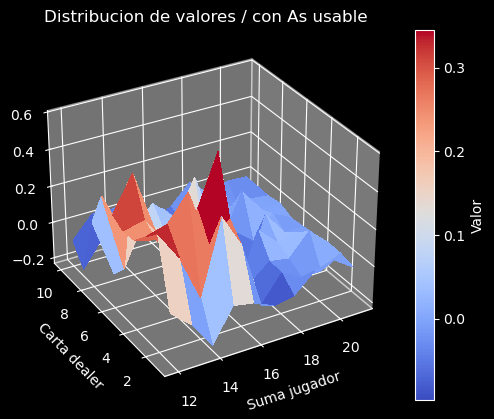

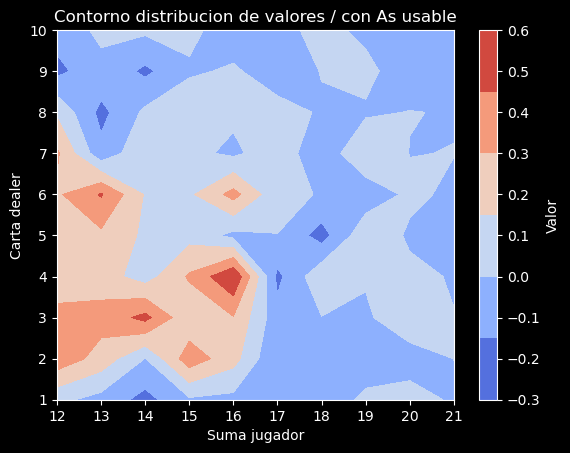

In [474]:
value_dif_thorp_ausable = {k: usable_a_policy_value[k] - thorp_value[k]  for k in usable_a_policy_value if k in thorp_value}

plot_value_distribution(value_dif_thorp_ausable)

Comparando nuestra politica (usando el as usable) contra el Valor que se obtiene utilizando la política de thorp. Observamos una diferencia positiva de hasta 0.6 de diferencia en el valor cuando la suma del jugador es entre 12 y 16, la carta del dealer es mala (entre 2 y 6) y el jugador tiene as usable

In [475]:
np.mean(list(value_dif_thorp_ausable.values()))

np.float64(0.01648758039616055)

En promedio el valor en cada estado de la politica "thorp con a usable" que definimos es mayor que el obtenido con la política thorp.

### First-Visit MC para estimar $Q$ con exploración inicial

Cuando queremos estimar la función de valor $Q$ para una política dada, tenemos el problema de que no tenemos una política exploratoria. Por ende podría no visitar todos los estados y acciones. Para resolver esto, podemos usar la técnica de exploración inicial donde se elige un estado aleatorio ($S_0$) y una acción aleatoria ($A_0$) y se juega un episodio desde ahí. Esto nos permite explorar el espacio de estados y acciones. 

> Notar que la política no cambia, solo se elige un estado y acción aleatorios para empezar a jugar.

> El desafío en Gymnasium es que no podemos elegir el estado inicial. Pero podemos intentar "hacer trampa" y modificar su estado interno. Esto no es recomendable, pero para fines de este laboratorio lo vamos a hacer.


$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }Q(s,a)\text{ con exploración inicial):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{la política a evaluar.}\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a) \in \mathbb{R}\quad \text{(valores arbitrarios)},\quad \forall\, s \in S,\; a \in A(s),\\
& \quad \text{Returns}(s,a) \leftarrow \varnothing,\quad \forall\, s \in S,\; a \in A(s).\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Elegir al azar un estado inicial } S_0 \in S \text{ y una acción } A_0 \in A(S_0).\\
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, S_1, A_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\; T-2,\; \ldots,\; 0: \\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } (S_t,A_t) \notin \{(S_0,A_0),\,(S_1,A_1),\,\ldots,\,(S_{t-1},A_{t-1})\}: \\
& \quad\quad\quad \text{Returns}(S_t,A_t) \leftarrow \text{Returns}(S_t,A_t) \cup \{G\}.\\
& \quad\quad\quad Q(S_t,A_t) \leftarrow \text{average}\Bigl(\text{Returns}(S_t,A_t)\Bigr).\\[6pt]
\textbf{Retornar:} & \quad Q.
\end{aligned}
$$


In [476]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv

# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py
# https://gymnasium.farama.org/api/wrappers/#gymnasium.Wrapper
class BlackjackEnvWrapper(BlackjackEnv):
    def set_state(self, state):
        """
        Fija el estado inicial deseado.
        state: (player_sum, dealer_card, usable_ace)
        """
        player_sum, dealer_card, usable = state
        # Configuramos la mano del jugador
        if usable:
            # Para tener un as usable, construimos una mano que contenga un 1 y otra carta que
            # haga que la suma (1 + otra carta + 10) sea player_sum.
            card = player_sum - 11
            # Aseguramos que la otra carta esté en el rango permitido (1 a 10)
            card = max(1, min(card, 10))
            self.player = [1, card]
        else:
            # Sin as usable, buscamos dos cartas que sumen player_sum
            # Esto es una simplificación; se podría mejorar para asegurarse de no incluir un 1.
            if player_sum == 21:
                # Si la suma es 21, aseguramos que una de las cartas sea un 10
                card1 = 10
                card2 = 11
            else:
                    card1 = player_sum // 2
                    card2 = player_sum - card1
                    card1 = max(2, min(card1, 10))
                    card2 = max(2, min(card2, 10))
            self.player = [card1, card2]
        
        # Configuramos la mano del dealer de modo que su carta visible sea la deseada.
        self.dealer = [dealer_card, np.random.randint(1, 11)]


In [477]:
def generate_episode_with_initial_exploration(policy, env):
    """
    Genera un episodio utilizando la política dada, con exploración inicial.
    """
    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(4, 22)   # suma entre 4 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    state = (player_sum, dealer_card, usable)

    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()
    step = 1
    
    done = False
    while not done:
        if step == 1:
            action = env.action_space.sample()
            step += 1
        else: 
            action = policy(state)
        new_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, new_state))
        done = terminated or truncated
        state = new_state
        step += 1

    return episode



In [478]:
env_wrapped = BlackjackEnvWrapper(env)
generate_episode_with_initial_exploration(sutton_policy, env_wrapped)

[((12, 2, 1), np.int64(1), 0.0, (19, 2, 1)),
 ((19, 2, 1), 1, 0.0, (12, 2, 0)),
 ((12, 2, 0), 1, 0.0, (15, 2, 0)),
 ((15, 2, 0), 1, 0.0, (20, 2, 0)),
 ((20, 2, 0), 0, 0.0, (20, 2, 0))]

In [479]:
def first_visit_mc_q_prediction_ie(policy, env, number_episodes, gamma=1.0):
    Q = defaultdict(float)  # Valor estimado de cada estado
    returns = defaultdict(lambda:[])  # Lista de retornos para cada estado,accion
    for _ in tqdm(range(number_episodes)):
        episode = generate_episode_with_initial_exploration(policy, env)
        G = 0  # Retorno
        T = len(episode)
        t = T-1
        while t>= 0:
            state, action, reward, _ = episode[t]
            G = reward + gamma * G
            # Solo consideramos el primer estado visitado en el episodio
            if (state,action) not in [(s,a) for s,a,_,_ in episode[:t]]:
                returns[state,action].append(G)
                Q[state,action] = np.mean(returns[state,action])
            t -= 1
    return Q

In [480]:
sab_q_value = first_visit_mc_q_prediction_ie(sutton_policy, env_wrapped, number_episodes=50000)

100%|██████████| 50000/50000 [00:08<00:00, 6015.36it/s]


In [481]:
sab_q_value[(21, 5, 0), 0]

np.float64(0.8644578313253012)

Q en el estado (21, 5, 0) ejecutando la acción STICK, tiene un retorno esperado (recompensa) de 0.88. Aunque el jugador tenga la mejor suma posible, el valor esperado nunca será 1 ya que el dealer tiene probabilidades de empatar.

In [482]:
sab_q_value[(21, 5, 0), 1] # Por que da esto?

np.float64(-1.0)

Originalmente el resultado de Q en el estado (21, 5, 0) ejecutando la accion HIT era 0 ya que:
- Por definición de la sutton policy, nunca se ejecuta esta acción cuando la suma del jugador es 21
- Por como estaba definida la función set_state dentro del Wrapper, si randomicamente la suma del jugador era 21 y as_usable era 0, en el self.player se iban a pasar las cartas 10 y 10, por lo que tampoco se exploraba el estado con esa acción mediante la exploración inicial.

Haciendo un cambio en el Wrapper, y pasando en el self.player las cartas 10 y 11 (aunque el 11 como carta no exista en el juego) logramos que el estado (21, 5, 0) con la acción HIT, sea explorado, que es el objetivo de hacer exploración inicial.

El estado (21,5,0) es un estado imposible de alcanzar en el primer step ya que solamente se podría sumar 21 con un as usable, y esto daría un estado inicial (21,5,1).
Si bien se randomiza el estado inicial para hacer la exploración inicial, en la función set state
En el estado (21, 5, 0) la Sutton Policy siempre ejecuta la acción STICK, por lo que la acción HIT no será explorada y no actualizará el valor estimado.

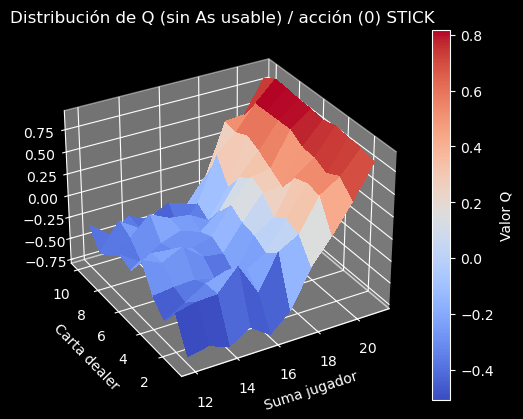

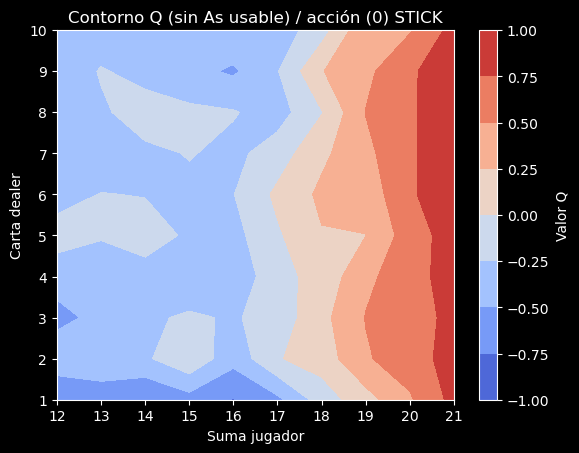

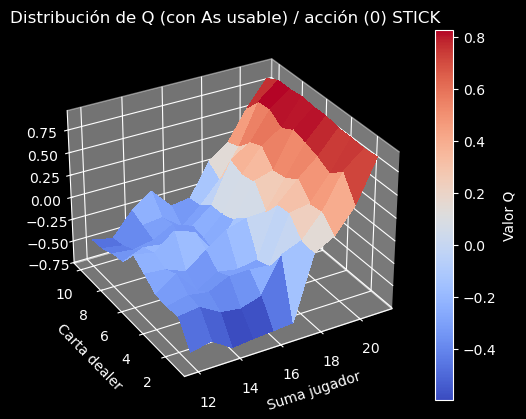

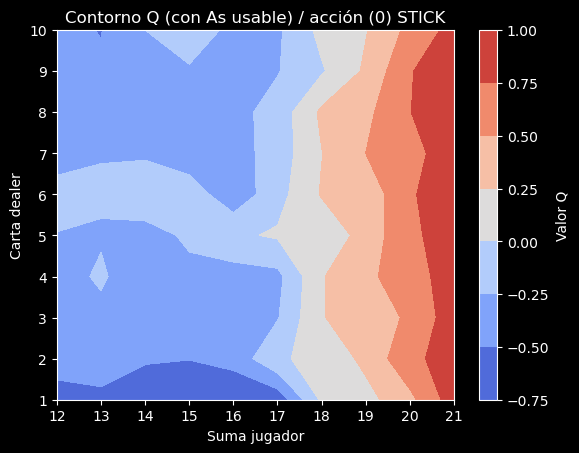

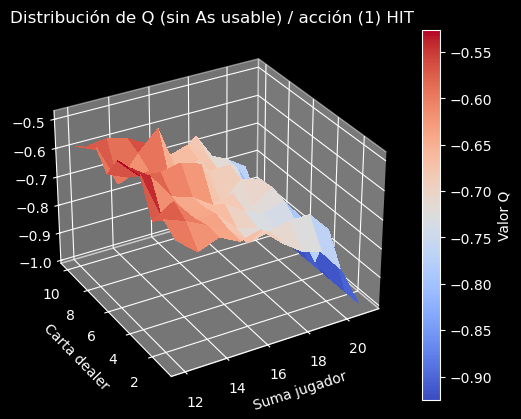

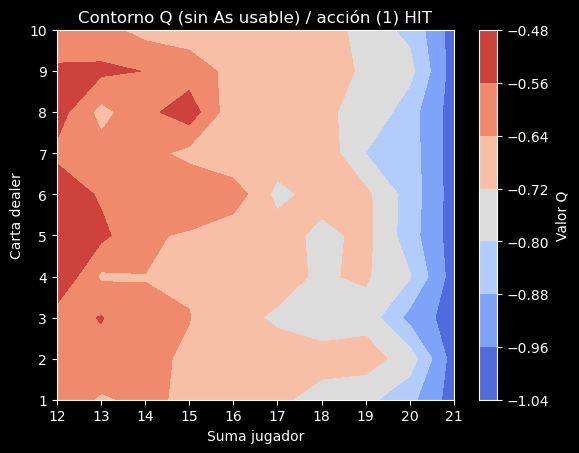

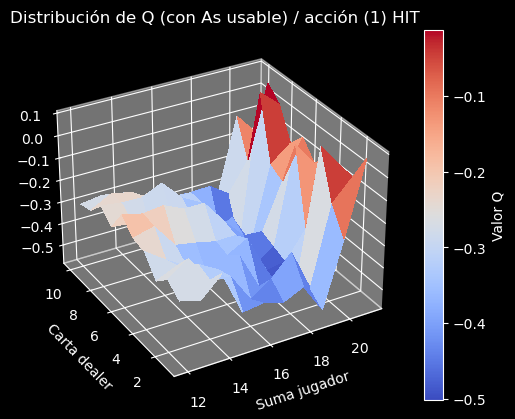

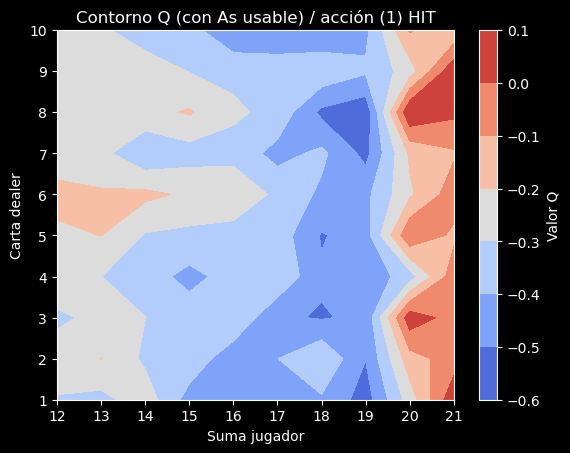

In [483]:
plot_Q_distribution(sab_q_value)

100%|██████████| 50000/50000 [00:07<00:00, 6495.13it/s]


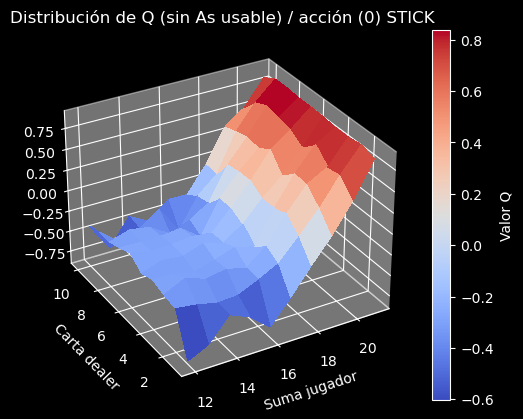

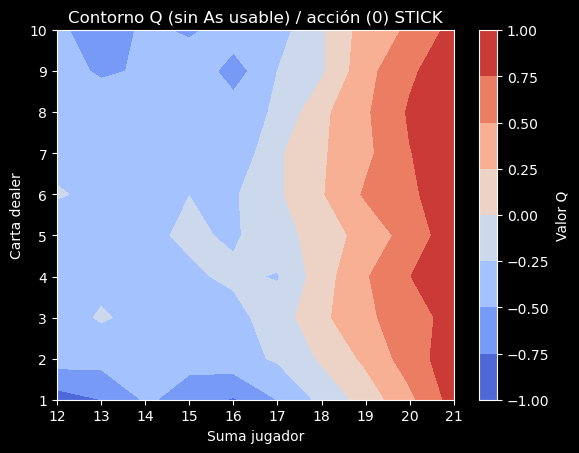

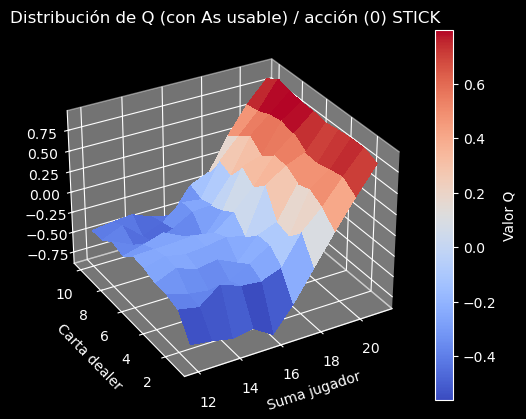

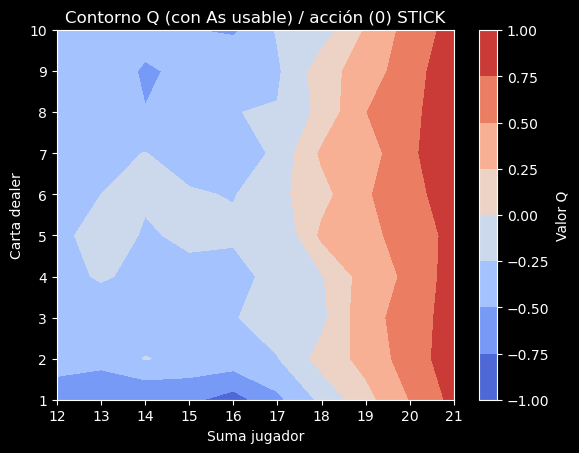

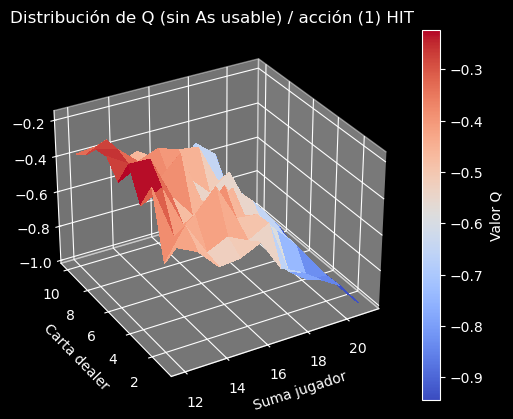

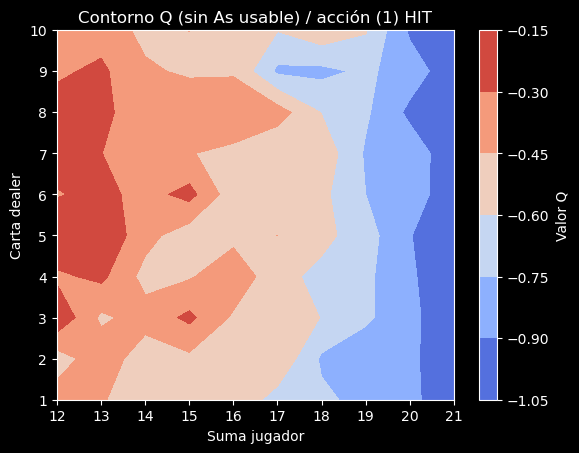

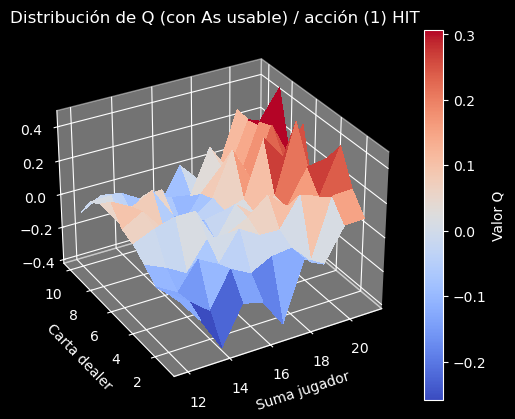

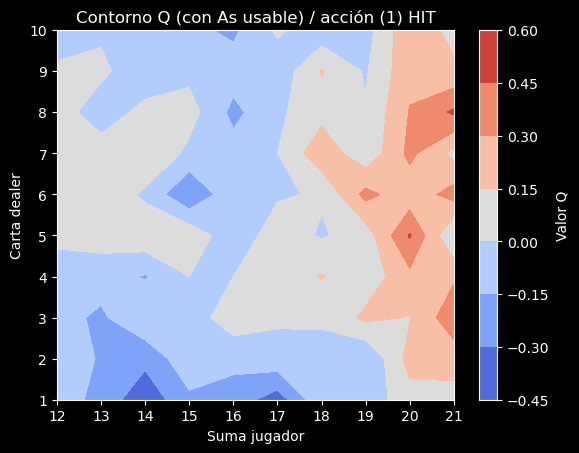

In [484]:
thorp_q_value = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=50_000)
plot_Q_distribution(thorp_q_value)

## **Tareas**

1. Implementar el algoritmo de Monte Carlo First Visit para estimar la función de valor $V$ y $Q$ para la política definida.
2. Comparar las estimaciones de la función de valor para distintos episodios (ej: 100, 10000, 50000, 500000). 
3. Elaborar una política diferente que tenga en cuenta el As usable y estimar su función de valor.
4. [extra] Implementar el algoritmo un algoritmo de control Monte Carlo para estimar la politica óptima. Puede ser MC ES para control (cap 5.3 del libro) o on-policy MC control (cap 5.4 del libro). Graficar resultados y comparar con politicas anteriores. ¿ Puede asegurar que "la casa siempre gana" ? 🎰

2. Comparar las estimaciones de la función de valor para distintos episodios (ej: 100, 10000, 50000, 500000). 

Cantidad de Episodios : 100


100%|██████████| 100/100 [00:00<00:00, 4596.25it/s]


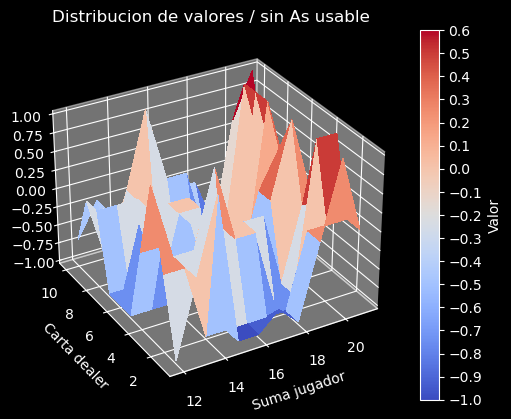

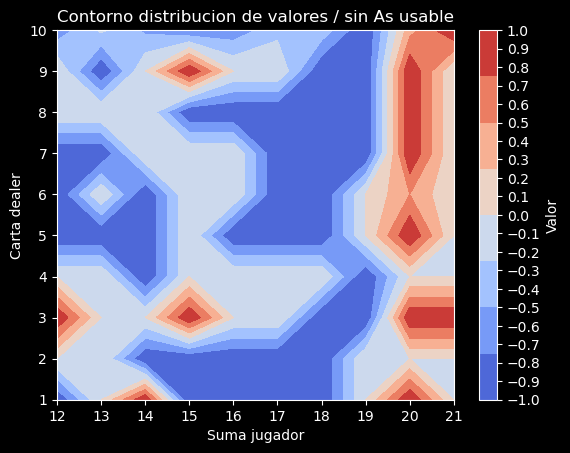

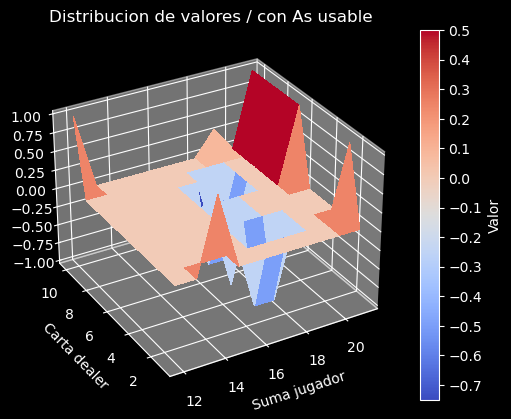

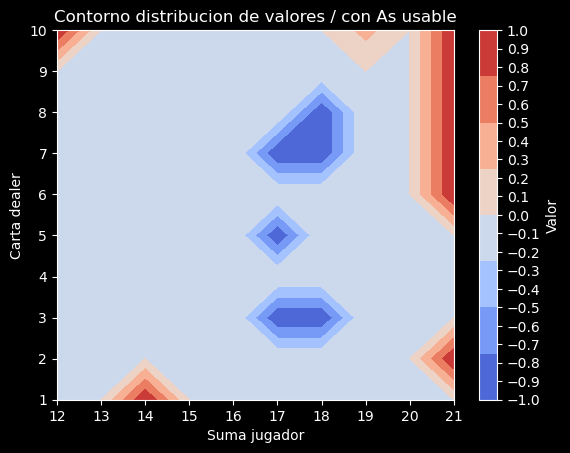

Cantidad de Episodios : 1000


100%|██████████| 1000/1000 [00:00<00:00, 5486.06it/s]


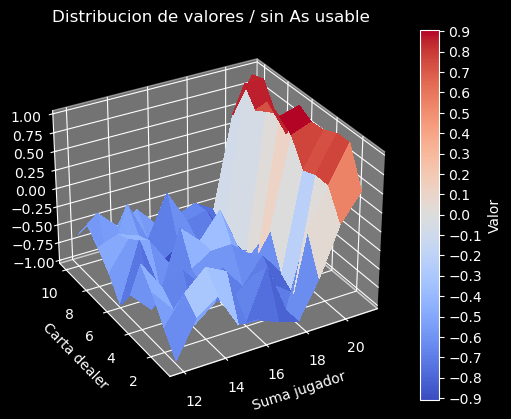

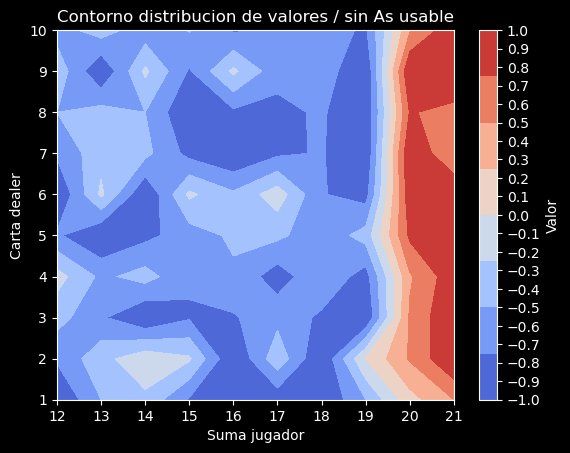

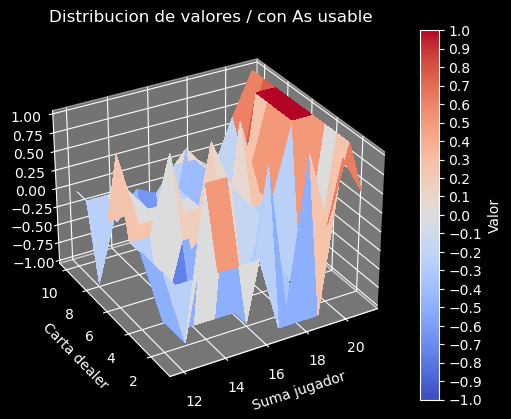

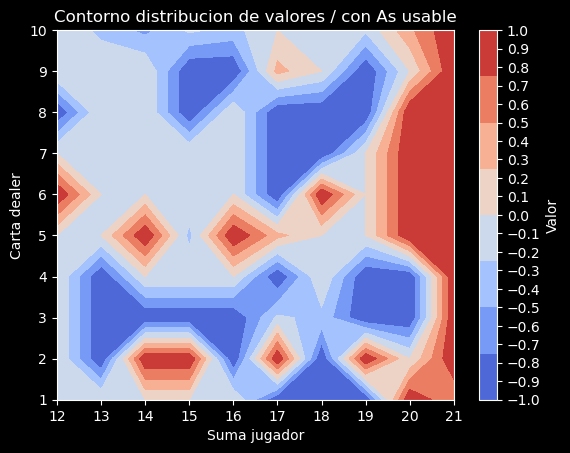

Cantidad de Episodios : 10000


100%|██████████| 10000/10000 [00:01<00:00, 7361.35it/s]


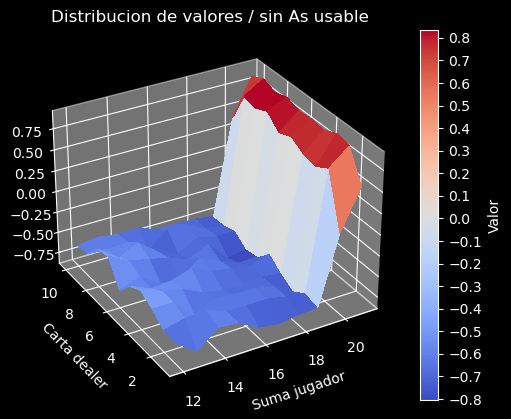

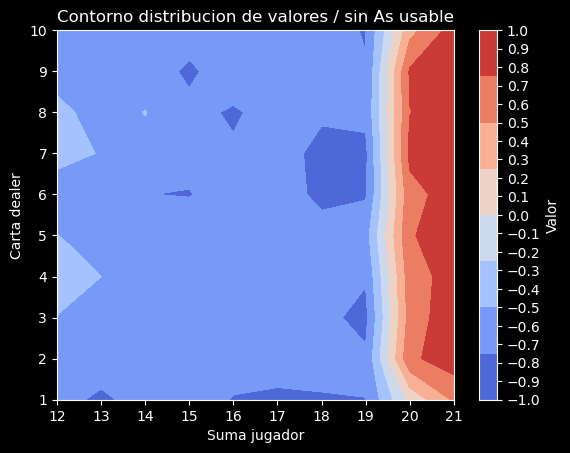

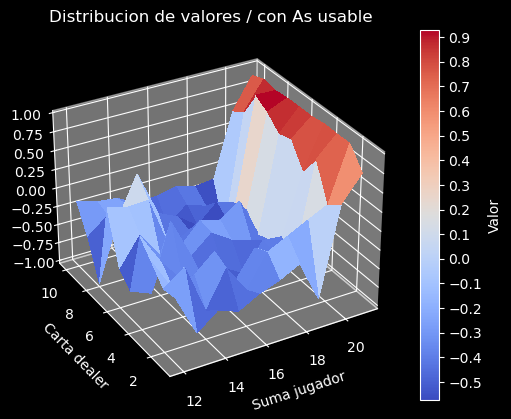

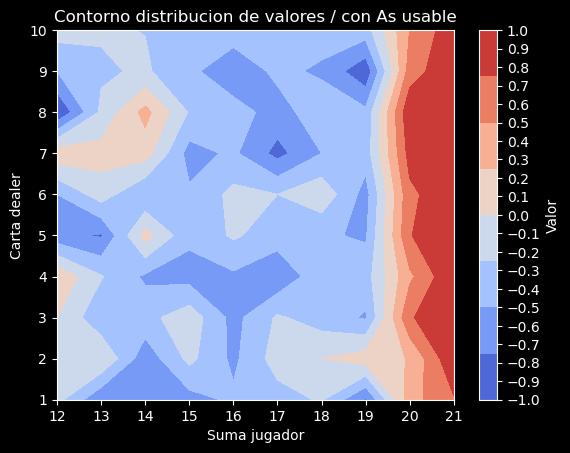

Cantidad de Episodios : 100000


100%|██████████| 100000/100000 [00:20<00:00, 4983.83it/s]


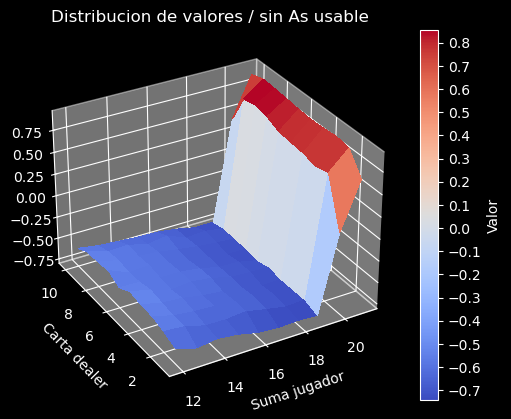

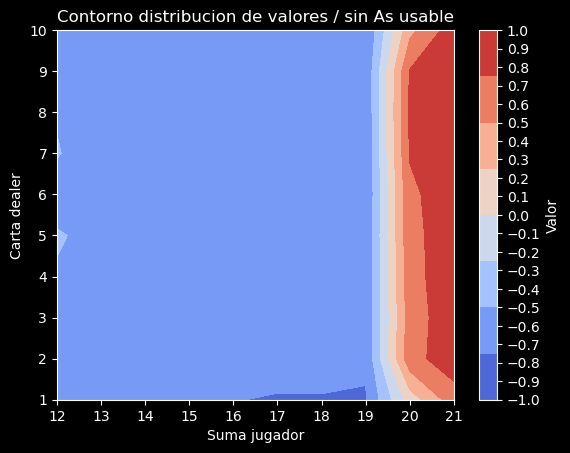

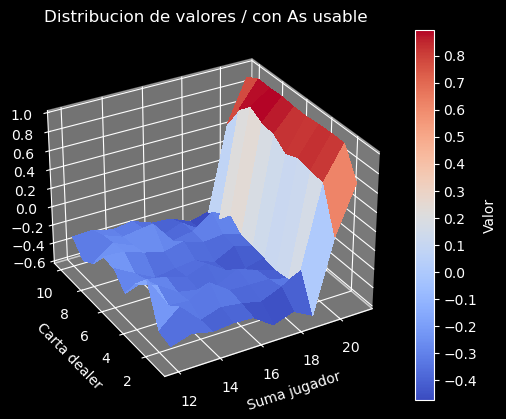

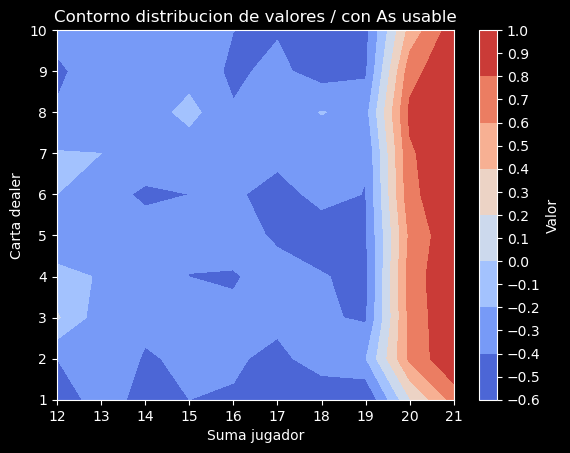

Cantidad de Episodios : 500000


100%|██████████| 500000/500000 [06:44<00:00, 1236.15it/s]


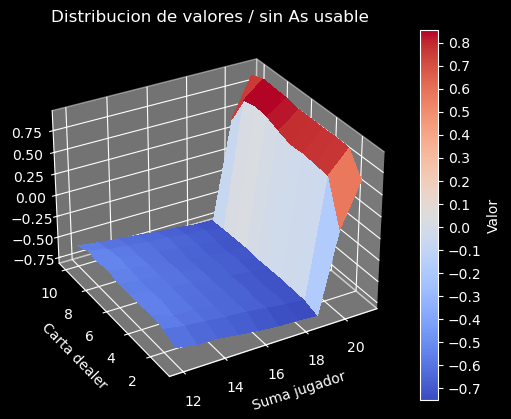

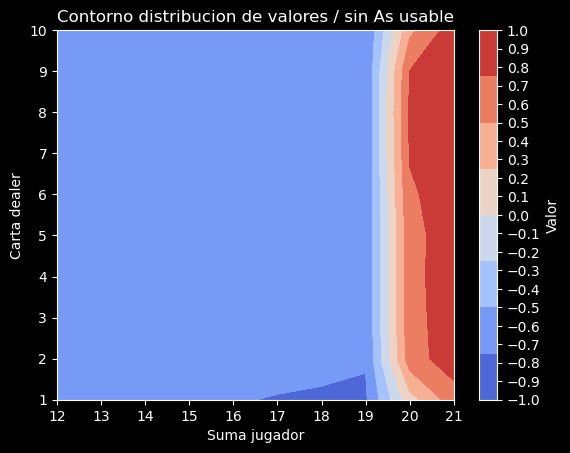

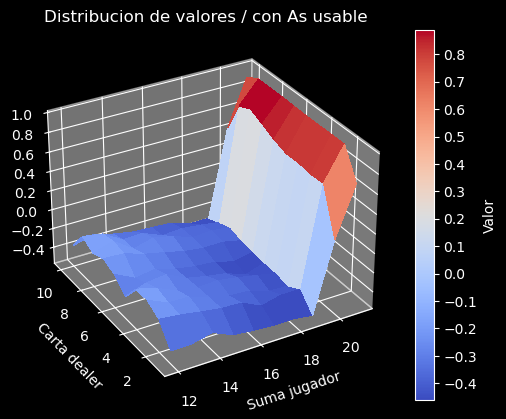

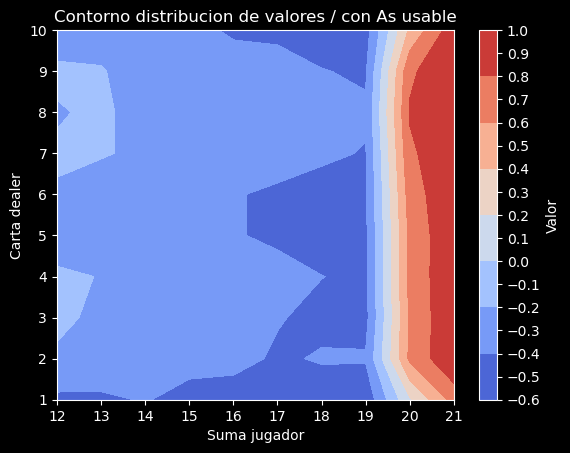

In [508]:
for episode_n in [100,1000,10000,100000,500000]:
    print(f"Cantidad de Episodios : {episode_n}")
    sab_value = first_visit_mc_prediction(sutton_policy, env, episode_n)
    plot_value_distribution(sab_value)

Se puede observar claramente como en la primera iteración (100 episodios) existe mucho ruido y muchos estados sin visitar, con valor 0 que es el asignado arbitrariamente al inciar el algoritmo.

A medida que aumentamos la cantidad de episodios podemos observar como van disminuyendo los picos que se corresponden con la poca cantidad de veces que el algoritmo visita los estados y la aproximación de V es mas real.
Si el número de episodios tiende a infinito, el algoritmo converge a la esperanza real.

4. Implementar el algoritmo un algoritmo de control Monte Carlo

In [485]:
def generate_episode_with_initial_exploration_2(policy, env):
    """
    Genera un episodio utilizando la política dada (como diccionario), con exploración inicial.
    """

    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(4, 22)   # suma entre 4 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    state = (player_sum, dealer_card, usable)

    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()
    step = 1
    
    done = False
    while not done:
        if step == 1:
            action = env.action_space.sample()
            step += 1
        else: 
            action = policy[state]
        new_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, new_state))
        done = terminated or truncated
        state = new_state
        step += 1

    return episode


In [486]:
def first_visit_mc_control_prediction_ie(env, number_episodes, gamma=1.0):
    optimal_policy = defaultdict(lambda: HIT)  # Política inicial (todas acciones son HIT)
    Q = defaultdict(float)  # Valor estimado de cada estado
    returns = defaultdict(lambda:[])  # Lista de retornos para cada estado,accion
    for _ in tqdm(range(number_episodes)):
        
        episode = generate_episode_with_initial_exploration_2(optimal_policy, env)
        G = 0  # Retorno
        T = len(episode)
        t = T-1
        while t>= 0:
            state, action, reward, _ = episode[t]
            G = reward + gamma * G
            # Solo consideramos el primer estado visitado en el episodio
            if (state,action) not in [(s,a) for s,a,_,_ in episode[:t]]:
                returns[state,action].append(G)
                Q[state,action] = np.mean(returns[state,action])
                optimal_policy[state] = np.argmax([Q[state, a] for a in range(env.action_space.n)])
            t -= 1
            
    return optimal_policy

In [487]:
optimal_policy = first_visit_mc_control_prediction_ie(env_wrapped,1000000, gamma=1.0)

100%|██████████| 1000000/1000000 [08:51<00:00, 1880.71it/s]


In [488]:
def opt_policy(observation): 
    return optimal_policy[observation]

In [499]:
optimal = first_visit_mc_prediction(lambda obs: optimal_policy[obs], env, number_episodes=100_000)

100%|██████████| 100000/100000 [00:19<00:00, 5100.89it/s]


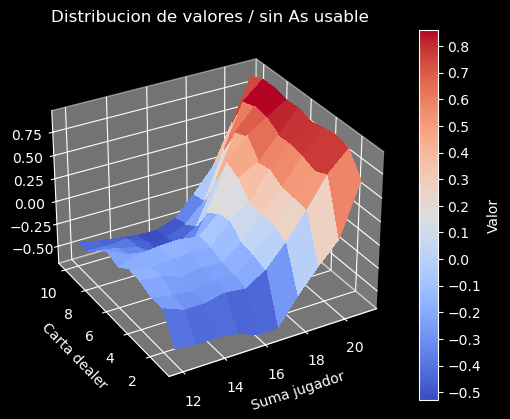

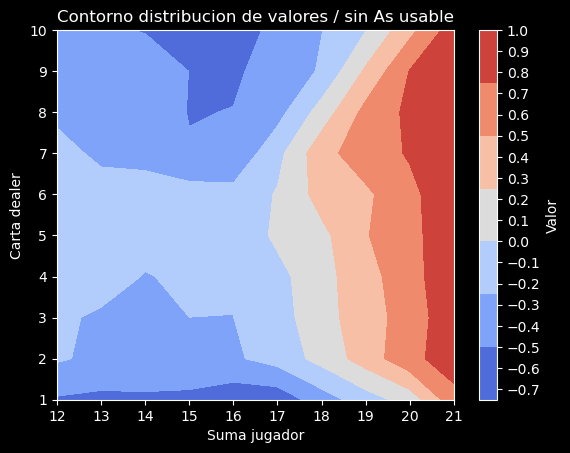

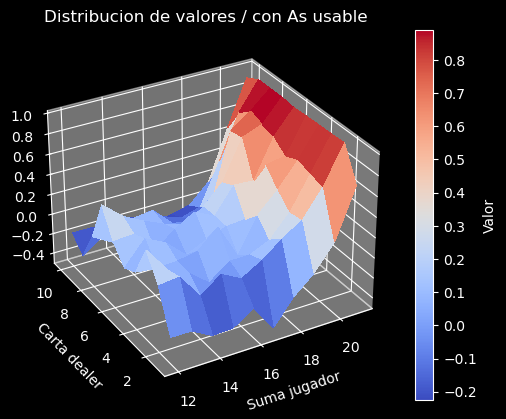

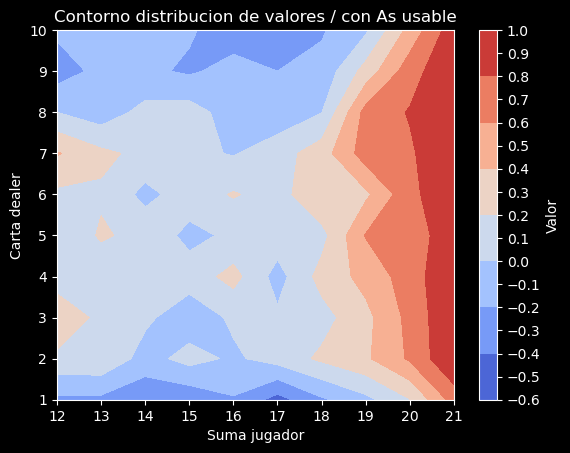

In [500]:
plot_value_distribution(optimal)

Comparamos la políctica optima vs la politica generada previamente que utilizaba el as usable para decidir la acción a tomar

In [501]:
value_dif_optimal_a_usable = {k: optimal[k] - usable_a_policy_value[k]  for k in optimal if k in usable_a_policy_value}

In [502]:
np.mean(list(value_dif_optimal_a_usable.values()))

np.float64(0.019309800810769082)

En promedio, la política optima tiene valores estimados mayores para los estados

## ¿La casa siempre gana?

In [496]:
def k_hands_simulation(env,policy,k=10000):
    """
    Simula k manos de blackjack utilizando la política dada.
    Args:
        env: Entorno de OpenAI Gym.
        policy: Función que toma un estado y devuelve una acción.
        k: Número de manos a simular.
    Returns:
        total_reward: Recompensa total obtenida en las k manos.
        manos_ganadas: Numero de manos ganadas.
        manos_perdidas: Numero de manos perdidas.
        manos_empatadas: Numero de manos empatadas.
        
    """
    total_reward = 0
    manos_ganadas = 0
    manos_perdidas = 0
    manos_empatadas = 0
    env.reset()
    for _ in tqdm(range(k)):
        episode = generate_episode(policy, env)
        total_reward += episode[-1][2]  # Recompensa del último paso
        if episode[-1][2] == 1:
            manos_ganadas += 1
        elif episode[-1][2] == -1:
            manos_perdidas += 1
        else:
            manos_empatadas += 1

    return total_reward, manos_ganadas, manos_perdidas, manos_empatadas

In [503]:
k = 500000
total_reward,manos_ganadas,manos_perdidas,manos_empatadas =  k_hands_simulation(env, lambda obs: optimal_policy[obs],k)

100%|██████████| 500000/500000 [00:44<00:00, 11209.17it/s]


In [505]:
print(f"Jugando {k} manos de blackjack con la política óptima: el jugador ganó en el {manos_ganadas/k:.1%} de las manos y perdió en el {manos_perdidas/k:.1%}")
if manos_perdidas > manos_ganadas:
    print("Podemos decir que aun jugando con la política óptima, la casa siempre gana.")
else:
    print("Podemos decir que jugando con la política óptima, el jugador gana.")

Jugando 500000 manos de blackjack con la política óptima: el jugador ganó en el 43.1% de las manos y perdió en el 48.2%
Podemos decir que aun jugando con la política óptima, la casa siempre gana.
